# Trabajo Final de Master

Este notebook contiene los códigos y desarrollos para estudiar diferentes modelos de movilidad y aplocarlos para el caso puntual de la ciudad de Bogotá

### Primera Parte. Tratamiento de datos de la encuesta de movilidad del 2019

En esta primera parte se hace un primer llamado a la encuesta de movilidad del año 2019 de Bogotá, en donde se estudiará la calidad de la fuente de datos y se crearan matrices origen destino para todos los medios de transporte, y así verificar si los datos se ajustan a un modelo gravitacional.

In [27]:
# Calling the libreries 
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import geopy.distance
from shapely.geometry import LineString
from pyproj import Geod
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# Declaring the paths of the trips data
trips_path = r'./Encuesta de Movilidad 2019/EODH/Archivos_CSV/ViajesEODH2019.csv'
# Path of the population data
houses_path = r'./Encuesta de Movilidad 2019/EODH/Archivos_CSV/HogaresEODH2019.csv'
# Path of the ZATs shapefiles
shape_path = r'./Encuesta de Movilidad 2019/Zonificacion_(shapefiles)/ZONAS/ZONAS/ZAT.shp'
# Path of the streets shapefile
streets_path = r'./Encuesta de Movilidad 2019/Zonificacion_(shapefiles)/Malla_Vial_Integral_Bogota_D_C/Malla_Vial_Integral_Bogota_D_C.shp'
# Path of the "Localidades" shapefile
loc_path = r'./Encuesta de Movilidad 2019/Zonificacion_(shapefiles)/loca/Loca.shp'
# Converting the CSV in a pandas dataframe
trips_df = pd.read_csv(trips_path, sep = ';')
# Converting the population data to dataframe
houses_df = pd.read_csv(houses_path, sep= ';', low_memory=False)
# Calling the ZAT's shapefile
zats_map = gpd.read_file(shape_path)
# Calling the streets shapefile
streets_map = gpd.read_file(streets_path)
# Calling the "Localidades" shapefile
loc_map = gpd.read_file(loc_path)

# Computing the centroid of each zat
zats_map['center'] = zats_map.to_crs('+proj=cea').centroid.to_crs(zats_map.crs)

# Function which plots the place where a zat is located in Bogotá 
def one_zat(zat):
    df = zats_map[zats_map['ZAT']==zat]
    x_center = df['center'].x.iloc[0]
    y_center = df['center'].y.iloc[0]
    x_max = x_center+0.06
    x_min = x_center-0.06
    y_max = y_center+0.06
    y_min = y_center-0.06
    fig, ax = plt.subplots(1, 1, figsize=(25, 25))
    streets_map.plot(ax = ax, color='grey')
    df.plot(color='g', ax=ax)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    plt.title('ZAT number {}'.format(zat), fontsize=40)
    plt.show()

# Function which plots the zat of origin and destination of a trip
def org_dest(zat_origin, zat_destination):
    x_origin = zats_map[zats_map['ZAT'] == zat_origin ]['center'].x.iloc[0]
    x_destination = zats_map[zats_map['ZAT'] == zat_destination]['center'].x.iloc[0]
    y_origin = zats_map[zats_map['ZAT'] == zat_origin ]['center'].y.iloc[0]
    y_destination = zats_map[zats_map['ZAT'] == zat_destination]['center'].y.iloc[0]
    x_max = max([x_origin, x_destination])+0.03
    x_min = min([x_origin, x_destination])-0.03
    y_max = max([y_origin, y_destination])+0.03
    y_min = min([y_origin, y_destination])-0.03
    fig, ax = plt.subplots(1, 1, figsize=(25, 25))
    streets_map.plot(ax = ax, color='grey')
    zats_map[zats_map['ZAT'] == zat_origin ].plot(color='g', ax=ax)
    zats_map[zats_map['ZAT'] == zat_destination].plot(color='r', ax=ax)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    plt.title('ZAT of origin: {}, ZAT of destination: {}'.format(zat_origin, zat_destination), fontsize=40)
    plt.show()



Ok como una primera aproximación no se van a filtrar los datos por tiempos de viaje, ni velocidades, por lo cual, en esta primera parte se tendrán en cuenta todos los datos.
La otra cuestión es que, como me sucedio en mi TFG, el muestreo sobre los de mas municipios está mal hecho, con los datos utilizados Bojaca tendría una población mayor a Faca y eso obviamente no es congruente con la vida real y el modelo estaría incorrecto, por lo cual, de nuevo, se van a utilizar solo datos en donde los vijes sean en Bogotá o Soacha.

In [35]:
# Filtering the data in order to take only the trips in Bogotá and Soacha
trips_df = trips_df[(trips_df['mun_origen'] == 11001) | (trips_df['mun_origen'] == 25754)]
trips_df = trips_df[(trips_df['mun_destino'] == 11001) | (trips_df['mun_destino'] == 25754)]
houses_df = houses_df[(houses_df['municipio'] == 11001) | (houses_df['municipio'] == 25754)]

In [36]:
# Computing the population per zat
population = houses_df[['zat_hogar', 'p7_total_personas']]
population = population.groupby('zat_hogar').agg('sum').sort_values(by='p7_total_personas', ascending=False)

Dado que el modelo gravitacional escala como $r^{-\alpha}$, no podemos tener en cuenta viajes dentro de una misma ZAT, por lo cual estos serán filtrados.

In [37]:
# Computing the number of trips between diferent zats 
num_trips_df = trips_df[['zat_origen', 'zat_destino']]
#num_trips_df['trips'] = np.ones(len(num_trips_df)) 
num_trips_df.loc[0:, ['trips']] = 1
num_trips_df = (num_trips_df.groupby(['zat_origen', 'zat_destino'], as_index=False)['trips']
                            .agg('sum')
                            .sort_values(by='trips', ascending=False))
num_trips_df = num_trips_df[num_trips_df['zat_destino'] != num_trips_df['zat_origen']]

Dado que el modelo gravitacional es simetrico, debemos sumar los viajes de "ida y de regreso" entre dos ZATs, por lo cual, vamos a convertir el numero de viajes en una matriz y la sumamos con su transpuesta para simetrizar esta matriz, y luego la convertimos en columna de nuevo. 

In [38]:
# Symmetrizing the number of trips between each zat
table = pd.pivot_table(num_trips_df, values='trips', index='zat_origen', columns='zat_destino').fillna(0)
table = table + table.T

sim_num_trips = (table.stack()
                      .to_frame()
                      .reset_index()
                      .rename(columns={'level_0': 'zat_origen', 'level_1': 'zat_destino', 0: 'trips'})
                      .sort_values(by='trips', ascending=False))
sim_num_trips = sim_num_trips[sim_num_trips['trips']>0]
#sim_num_trips

In [39]:
# Adding the centroid coordinates to the df

num_dis_trips = (num_trips_df.merge(zats_map[['ZAT', 'center']], left_on='zat_origen', right_on='ZAT')
                             .rename(columns={'center': 'Origin_center'})
                             .drop(columns='ZAT'))
num_dis_trips = (num_dis_trips.merge(zats_map[['ZAT', 'center']], left_on='zat_destino', right_on='ZAT')
                             .rename(columns={'center': 'Destination_center'})
                             .drop(columns='ZAT'))
#num_dis_trips.sort_values(by='trips', ascending=False)

In [40]:
# Adding the centroid coordinates to the symmetrical df

num_dis_sim = (sim_num_trips.merge(zats_map[['ZAT', 'center']], left_on='zat_origen', right_on='ZAT')
                             .rename(columns={'center': 'Origin_center'})
                             .drop(columns='ZAT'))
num_dis_sim = (num_dis_sim.merge(zats_map[['ZAT', 'center']], left_on='zat_destino', right_on='ZAT')
                             .rename(columns={'center': 'Destination_center'})
                             .drop(columns='ZAT')
                             .sort_values(by='trips', ascending=False))
num_dis_sim

,zat_origen,zat_destino,trips,Origin_center,Destination_center
0,530.0,551.0,139.0,POINT (-74.17593 4.63213),POINT (-74.18166 4.62800)
29708,551.0,530.0,139.0,POINT (-74.18166 4.62800),POINT (-74.17593 4.63213)
36271,776.0,775.0,112.0,POINT (-74.19802 4.57757),POINT (-74.19736 4.58356)
25603,775.0,776.0,112.0,POINT (-74.19736 4.58356),POINT (-74.19802 4.57757)
45336,1050.0,714.0,105.0,POINT (-74.15788 4.52832),POINT (-74.16040 4.55118)
...,...,...,...,...,...
20317,433.0,842.0,1.0,POINT (-74.09286 4.60852),POINT (-74.08922 4.67644)
49496,153.0,399.0,1.0,POINT (-74.03147 4.69940),POINT (-74.14835 4.67276)
49495,305.0,399.0,1.0,POINT (-74.13276 4.68631),POINT (-74.14835 4.67276)
49494,722.0,399.0,1.0,POINT (-74.15299 4.53344),POINT (-74.14835 4.67276)


In [41]:
line = LineString([num_dis_sim['Origin_center'].iloc[0], num_dis_sim['Destination_center'].iloc[0]])
geod = Geod(ellps = 'WGS84')
geod.geometry_length(line)/1000

0.7829163118920128

In [42]:
# Calculating the distances in meters
distance = []
geod = Geod(ellps = 'WGS84')
for i in range(len(num_dis_sim)):
    line = LineString([num_dis_sim['Origin_center'].iloc[i], num_dis_sim['Destination_center'].iloc[i]])
    dist = geod.geometry_length(line)
    distance.append(dist)

num_dis_sim['distance'] = distance
num_dis_sim

,zat_origen,zat_destino,trips,Origin_center,Destination_center,distance
0,530.0,551.0,139.0,POINT (-74.17593 4.63213),POINT (-74.18166 4.62800),782.916312
29708,551.0,530.0,139.0,POINT (-74.18166 4.62800),POINT (-74.17593 4.63213),782.916312
36271,776.0,775.0,112.0,POINT (-74.19802 4.57757),POINT (-74.19736 4.58356),666.616844
25603,775.0,776.0,112.0,POINT (-74.19736 4.58356),POINT (-74.19802 4.57757),666.616844
45336,1050.0,714.0,105.0,POINT (-74.15788 4.52832),POINT (-74.16040 4.55118),2542.549034
...,...,...,...,...,...,...
20317,433.0,842.0,1.0,POINT (-74.09286 4.60852),POINT (-74.08922 4.67644),7521.418003
49496,153.0,399.0,1.0,POINT (-74.03147 4.69940),POINT (-74.14835 4.67276),13298.175692
49495,305.0,399.0,1.0,POINT (-74.13276 4.68631),POINT (-74.14835 4.67276),2289.037644
49494,722.0,399.0,1.0,POINT (-74.15299 4.53344),POINT (-74.14835 4.67276),15414.883601


### Casos particulares

Analizando los dataframes, se encontro que, a la hora de introducir las poblaciones de cada ZAT en el dataframe "num_dis_sim", hay una cantidad considerable de viajes que se borran, lo cual sucede debido a que, en estas zonas no hay hogares en los cuales se realizó la encuesta, es decir, su población es cero, pero los viajes hacía estas zonas existen. 

Al revisar cuales zonas son estas zonas con población cero, se observó que son zonas rurales a las afueras de la ciudad, como por ejemplo la conejera en Suba, en donde hay una cantidad considerable de equipamentos deportivos, pero ahí no vive nadie.
Este tipo de comportamientos podrían repetirse en zonas como viveros, poligonos industriales o campus universitarios en donde normalmente no vive nadie, pero al ser zonas de trabajo o estudio se realizan muchos viajes a estas.

En estos casos particulares, el modelo gravitacional no es capaz de predecir este tipo de viajes dado que la población de estas zonas en principio es cero, pero al tener puestos de trabajo o una oferta de equipamentos, la gente va a viajar a dichas zonas.

[]

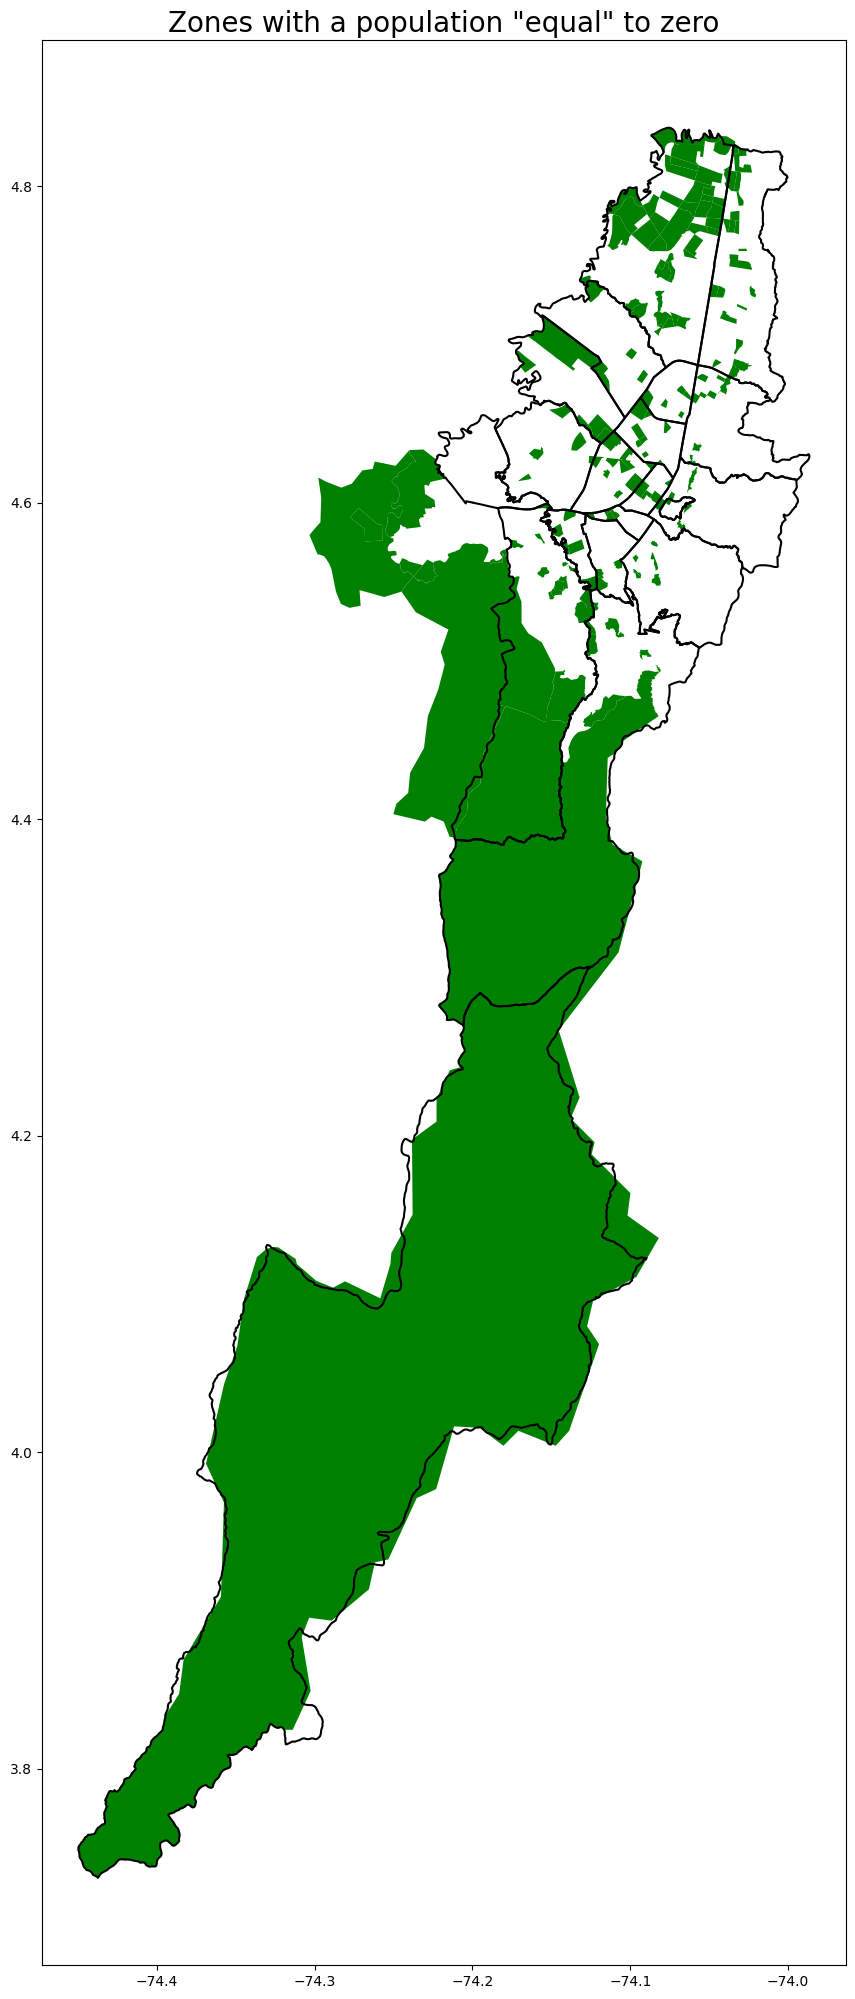

In [43]:
# Ploting the ZATs whit population equal to zero
mask = zats_map['ZAT'].isin(list(set(num_dis_sim['zat_origen'].unique())-set(population.index)))
pltn_zero = zats_map[mask]

fig, ax = plt.subplots(1, 1, figsize=(25, 25))
loc_map.boundary.plot(ax=ax, color='black')
pltn_zero.plot(color='g', ax=ax)
plt.title('Zones with a population "equal" to zero', fontsize = 20)
plt.plot()

In [44]:
num_trips_df[num_trips_df['zat_origen']==1]

,zat_origen,zat_destino,trips
50,1.0,33.0,14.0
53,1.0,41.0,2.0
54,1.0,669.0,2.0
49,1.0,9.0,2.0
51,1.0,38.0,1.0
52,1.0,39.0,1.0
55,1.0,1028.0,1.0


En el mapa aparecen zonas bastante importantes en la ciudad, como el aeropuerto, el parque Simon Bolivar (el mas grande de la ciudad), y equipamentos como bibliotecas.

El modelo gravitcional no es capas de modelar los viajes que se realizan desde y hacia estas zonas.

In [45]:
# Adding the number of person in the survey per zat 
num_dis_sim = (num_dis_sim.merge(population, left_on='zat_origen', right_on='zat_hogar')
                          .rename(columns={'p7_total_personas': 'Origin Population'}))
num_dis_sim = (num_dis_sim.merge(population, left_on='zat_destino', right_on='zat_hogar')
                          .rename(columns={'p7_total_personas': 'Dest Population'})
                          .sort_values(by='trips', ascending=False)
                          .drop(columns=['Origin_center', 'Destination_center']))
num_dis_sim = num_dis_sim[['zat_origen', 'zat_destino', 'Origin Population', 'Dest Population', 'distance', 'trips']]
# Droping the repeated values
num_dis_sim = num_dis_sim.iloc[::2]
num_dis_sim.head(10)

,zat_origen,zat_destino,Origin Population,Dest Population,distance,trips
0,530.0,551.0,518,145,782.916312,139.0
30008,776.0,775.0,311,184,666.616844,112.0
39910,714.0,1050.0,64,229,2542.549034,105.0
28473,783.0,782.0,230,187,860.003059,100.0
30084,776.0,777.0,311,274,899.246606,96.0
22115,744.0,743.0,115,471,906.773827,83.0
243,1006.0,553.0,178,244,570.037103,79.0
30472,782.0,784.0,187,265,1412.350471,77.0
30695,782.0,778.0,187,106,809.763373,75.0
30399,781.0,779.0,230,58,1289.865211,74.0


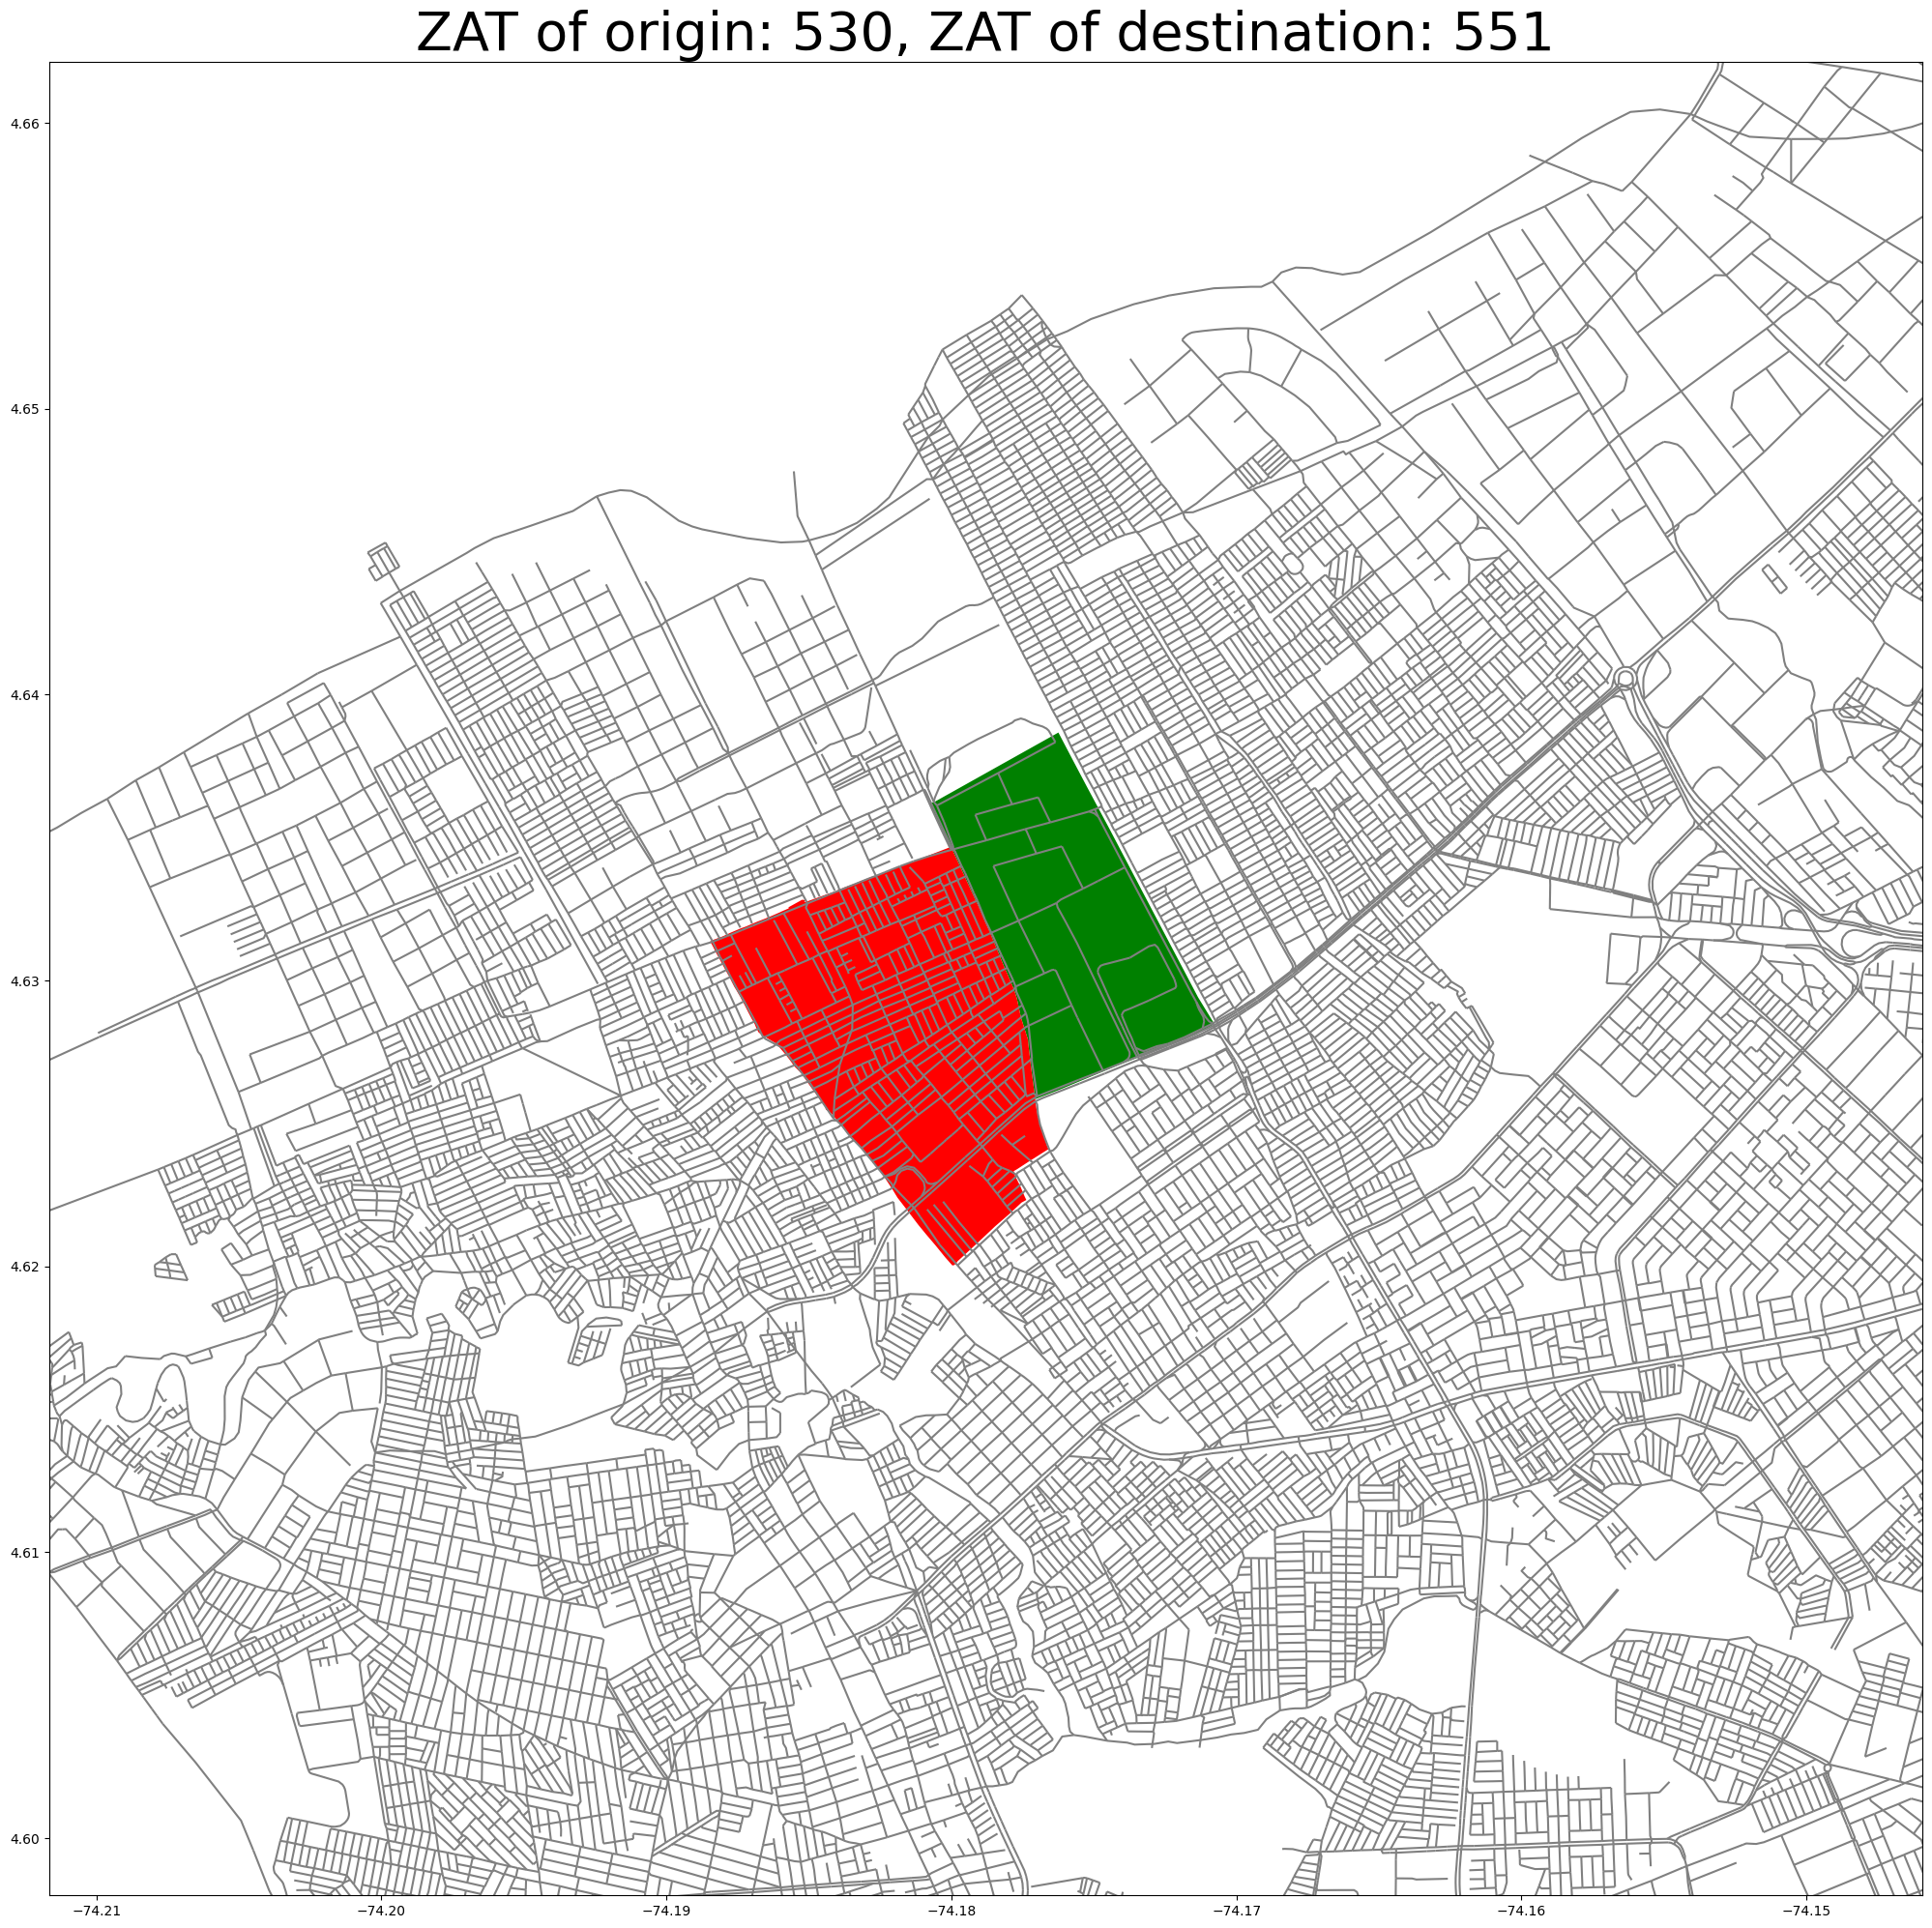

In [57]:
org_dest(530, 551)

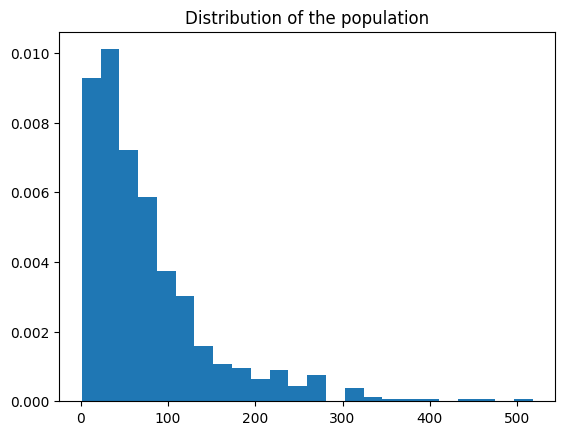

In [73]:
# Distribution of the population 
pltn_y, pltn_x = np.histogram(population['p7_total_personas'], bins=int(len(population)/30), density=True)
plt.stairs(pltn_y, pltn_x, fill=True)
plt.title('Distribution of the population')
plt.show()

[]

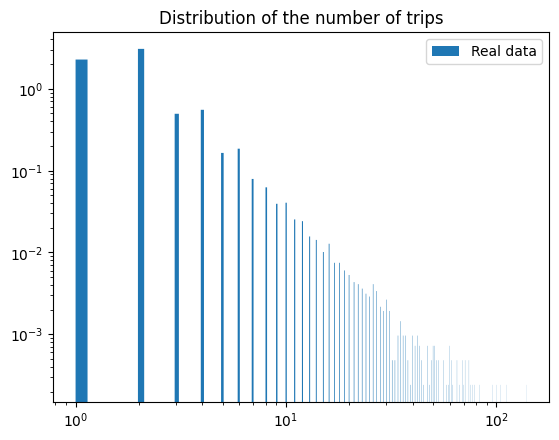

In [74]:
# Distribution of the number of trips
bins = int(len(num_dis_sim)/30)
data_trips_y, data_trips_x = np.histogram(num_dis_sim['trips'], bins=bins, density=True)
plt.stairs(data_trips_y, data_trips_x, fill=True, label='Real data')
plt.xscale('log')
plt.yscale('log')
plt.title('Distribution of the number of trips')
plt.legend()
plt.plot()

En la figura anterior podemos ver que el numero de personas que viajan entre dos zonas parece seguir una ley de potencias de la forma $ax^{-\alpha}$, por lo cual el modelo que de razón de la cantidad de viajes entre dos zonas debe seguir un mecanismo, el cual de como resultado una ley de potencias. 

### Fitting

Con los datos organozados debidamente, se va a definir la función del modelo y se ajustarán los datos utilizando el metodo curve_fit de scipy para obtener un primer estimado de los parametros del modelo, posteriormente se usarán tecnicas mas rigurosas como el most likelyhood estimator y, usando los resultados del curve_fit aplicar inferencia bayesiana.

La función a ajustar es

$T_{ij} = K\frac{P_iP_j}{d_{ij}^{\alpha}}$

In [75]:
# Declaring the gravity function
def gravity(Data, K, a):
    P_1, P_2, d = Data
    T = K*(P_1*P_2)/(d**a)
    return T

# Spliting the data
ppltn_1 = np.array(num_dis_sim['Origin Population'])
ppltn_2 = np.array(num_dis_sim['Dest Population'])
dist = np.array(num_dis_sim['distance'])
# Tupple with the free parameters
data = (ppltn_1, ppltn_2, dist)
# Array with the number of trips between zats
trips = np.array(num_dis_sim['trips'])

# Fiting the data with the model
popt, pcov = curve_fit(gravity, data, trips)
print(popt)
print(np.sqrt(np.diag(pcov)))

# Computing the R^2 value
theo_trips = gravity(data, popt[0], popt[1])
r2_score(trips, theo_trips)

[0.80027608 1.05438672]
[0.05279112 0.00922631]


0.10201358776935332

El ajuste obtenido nos da unos parametros $K=0.80027608$ y $\alpha=1.05438672$, por lo cual el modelo sería $T_{ij} = 0.8\frac{P_iP_j}{d_{ij}^{1.05}}$, pero al calcular el $R^2$, obtenemos un valor de $0.1$, dandonos a entender que el ajuste a este modelo no es el mejor precisamente.

[]

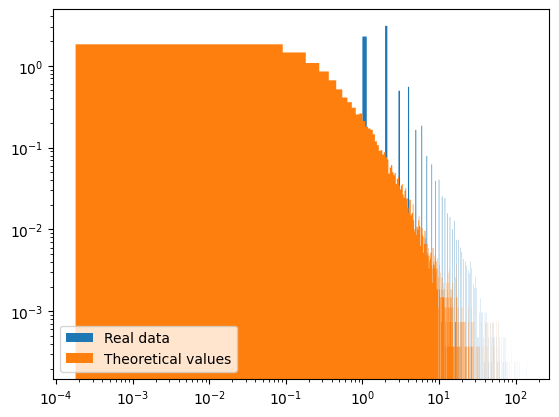

In [68]:
# Comparation between the distribution of trips given by the data and the model.
bins = int(len(num_dis_sim)/30)
data_trips_y, data_trips_x = np.histogram(num_dis_sim['trips'], bins=bins, density=True)
theo_trips_y, theo_trips_x = np.histogram(theo_trips, bins=bins, density=True)
plt.stairs(data_trips_y, data_trips_x, fill=True, label='Real data')
plt.stairs(theo_trips_y, theo_trips_x, fill=True, label='Theoretical values')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.plot()

Los datos serán ajustados a un modleo gravitacional modificado de la forma

$T_{ij} = K\frac{(P_iP_j)^{\beta}}{d_{ij}^{\alpha}}$

In [77]:
# Declaring the modified gravity function 
def mod_gravity(Data, K, a, b):
    P_1, P_2, d = Data
    T = K*(P_1*P_2)**b/(d**a)
    return T

# Fiting the data with the model
popt_mod, pcov_mod = curve_fit(mod_gravity, data, trips)
print(popt_mod)
print(np.sqrt(np.diag(pcov_mod)))

# Computing the R^2 value
mod_theo_trips = mod_gravity(data, popt_mod[0], popt_mod[1], popt_mod[2])
r2_score(trips, mod_theo_trips)

[38.26411357  0.75204802  0.40545009]
[2.30884537 0.00625166 0.00517236]


0.26442269847344857

El ajuste obtenido nos da unos parametros $K=38.26$, $\alpha=0.75$ y $\beta=0.4$, por lo cual el modelo sería $T_{ij} = 38.26\frac{(P_iP_j)^{0.4}}{d_{ij}^{0.75}}$, al calcular el $R^2$, obtenemos un valor de $0.26$, obteniendo una mejor con respect al modelo anterior, pero de todas formas el ajuste no es satisfactorio. 

[]

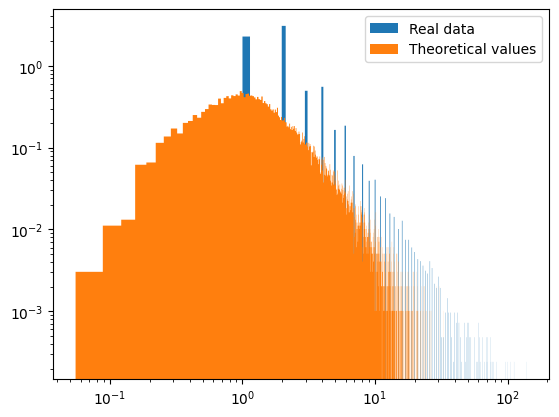

In [84]:
# Comparation between the distribution of trips given by the data and the modified model.
bins = int(len(num_dis_sim)/30)
data_trips_y, data_trips_x = np.histogram(num_dis_sim['trips'], bins=bins, density=True)
theo_trips_y, theo_trips_x = np.histogram(mod_theo_trips, bins=bins, density=True)
plt.stairs(data_trips_y, data_trips_x, fill=True, label='Real data')
plt.stairs(theo_trips_y, theo_trips_x, fill=True, label='Theoretical values')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.plot()

Como podemos observar, en ninguno de los dos casos de modelo gravitacional se ajustan a los datos de una manera satisfactoria, razón por la cual se debe seguir investigando y buscando que tipo de modelo que ajusta de una mejor manera.

Proximas tareas:
Ajustar la distribución de numero de viajes a una ley de potencias y encontrar dichos parametros. 
La idea sería, a partir de esta distribución encontrar que modelos o mecanismos dan como resultado un tipo de distribucíon de ley de potencias.

Sacar la distribución de numero de viajes antes de que se filtren los viajes donde las zonas tiene una población "nula".